In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score, precision_recall_fscore_support
)

In [7]:
DATA_DIR = "datasets/"
MODULE = "BBB"  # Đổi sang môn Tiếng Anh/Xã hội
PRESENTATIONS = ["2013B", "2013J"]

# --- CẤU HÌNH THỜI GIAN QUAN TRỌNG ---
# Model sẽ học dữ liệu tại các mốc thời gian này.
# Khi chạy Cron Job thực tế, bạn có thể predict ở bất kỳ ngày nào (ví dụ ngày 45), 
# model sẽ tự nội suy dựa trên những gì đã học ở ngày 30 và 60.
TIME_CHECKPOINTS = [14, 30, 60, 90, 120, 150, 180, 210] 

print(f"--- ĐANG XỬ LÝ: {MODULE} {PRESENTATIONS} ---")
print(f"--- TRAINING MODE: TIME-AWARE (Checkpoints: {TIME_CHECKPOINTS}) ---")

student_info = pd.read_csv(DATA_DIR + "studentInfo.csv")
student_reg = pd.read_csv(DATA_DIR + "studentRegistration.csv")
student_vle = pd.read_csv(DATA_DIR + "studentVle.csv")
student_ass = pd.read_csv(DATA_DIR + "studentAssessment.csv")

--- ĐANG XỬ LÝ: BBB ['2013B', '2013J'] ---
--- TRAINING MODE: TIME-AWARE (Checkpoints: [14, 30, 60, 90, 120, 150, 180, 210]) ---


In [8]:

# =========================================================
# 2. LỌC SINH VIÊN (SELF-PACED SIMULATION)
# =========================================================
# Chỉ lấy người đăng ký đúng hạn (date_registration <= 0) để giả lập môi trường Self-paced
# Loại bỏ nhiễu từ những người vào muộn phải học đuổi.

reg_filtered = student_reg[
    (student_reg["code_module"] == MODULE) & 
    (student_reg["code_presentation"].isin(PRESENTATIONS)) &
    (student_reg["date_registration"] <= 0) # <--- Lọc người vào muộn
]
valid_ids = reg_filtered["id_student"].unique()

students = student_info[
    (student_info["code_module"] == MODULE) & 
    (student_info["code_presentation"].isin(PRESENTATIONS)) &
    (student_info["id_student"].isin(valid_ids))
].copy()

# Label Dropout
students["dropout"] = np.where(students["final_result"] == "Withdrawn", 1, 0)
print(f"Số lượng sinh viên gốc (Unique Users): {len(students)}")


Số lượng sinh viên gốc (Unique Users): 3975


In [9]:

# =========================================================
# 3. DATA AUGMENTATION (TẠO DATASET ĐA THỜI ĐIỂM)
# =========================================================
augmented_data_list = []

for cutoff in TIME_CHECKPOINTS:
    # print(f"... Đang xử lý mốc thời gian: {cutoff} ngày")
    
    # 3.1 Cắt dữ liệu VLE (Hành vi) tính đến ngày cutoff
    vle_snapshot = student_vle[
        (student_vle["code_module"] == MODULE) &
        (student_vle["code_presentation"].isin(PRESENTATIONS)) &
        (student_vle["id_student"].isin(students["id_student"])) &
        (student_vle["date"] <= cutoff) # <--- Chỉ lấy quá khứ
    ]
    
    # Aggregation VLE
    vle_agg = vle_snapshot.groupby("id_student").agg(
        total_clicks=("sum_click", "sum"),
        active_days=("date", "nunique"),
        last_active=("date", "max")
    ).reset_index()
    
    # Feature Engineering (Tính toán các chỉ số tương đối)
    vle_agg["days_elapsed_program"] = cutoff # <--- Feature QUAN TRỌNG NHẤT: Báo cho AI biết đang ở ngày nào
    vle_agg["clicks_per_day"] = vle_agg["total_clicks"] / cutoff
    vle_agg["active_ratio"] = vle_agg["active_days"] / cutoff
    vle_agg["days_since_last_active"] = cutoff - vle_agg["last_active"]
    
    # Tính Recency (Tuần gần nhất hoạt động thế nào?)
    recent_clicks = vle_snapshot[vle_snapshot["date"] > (cutoff - 7)].groupby("id_student")["sum_click"].sum().reset_index(name="clicks_last_7_days")
    vle_agg = vle_agg.merge(recent_clicks, on="id_student", how="left").fillna(0)

    # 3.2 Cắt dữ liệu Assessment (Điểm số) tính đến ngày cutoff
    ass_snapshot = student_ass[
        (student_ass["id_student"].isin(students["id_student"])) &
        (student_ass["date_submitted"] <= cutoff)
    ]
    
    ass_agg = ass_snapshot.groupby("id_student").agg(
        num_assessments=("id_assessment", "nunique"),
        avg_score=("score", "mean"),
        pass_count=("score", lambda x: (x >= 40).sum())
    ).reset_index()
    
    # 3.3 Merge snapshot này với thông tin gốc
    # Lưu ý: Nhãn dropout không đổi, nhưng hành vi thay đổi theo cutoff
    merged = students[["id_student", "gender", "highest_education", "dropout"]].merge(vle_agg, on="id_student", how="left")
    merged = merged.merge(ass_agg, on="id_student", how="left")
    
    # Điền khuyết cho những người chưa làm gì tính đến cutoff
    merged["total_clicks"] = merged["total_clicks"].fillna(0)
    merged["clicks_per_day"] = merged["clicks_per_day"].fillna(0)
    merged["active_ratio"] = merged["active_ratio"].fillna(0)
    merged["days_since_last_active"] = merged["days_since_last_active"].fillna(cutoff) # Chưa học bao giờ -> Lười bằng số ngày cutoff
    merged["clicks_last_7_days"] = merged["clicks_last_7_days"].fillna(0)
    merged["num_assessments"] = merged["num_assessments"].fillna(0)
    merged["avg_score"] = merged["avg_score"].fillna(0)
    merged["pass_count"] = merged["pass_count"].fillna(0)
    
    # Quan trọng: Gán lại cột days_elapsed_program (vì merge left có thể sinh NaN nếu user ko có trong vle)
    merged["days_elapsed_program"] = cutoff
    
    augmented_data_list.append(merged)

# Gộp tất cả snapshots lại
final_df = pd.concat(augmented_data_list, ignore_index=True)
print(f"Kích thước dataset sau khi Augmentation: {final_df.shape}")
# (Kích thước sẽ lớn gấp N lần số lượng user gốc)


Kích thước dataset sau khi Augmentation: (31800, 15)


In [10]:

# =========================================================
# 4. CHUẨN BỊ TRAIN (SPLIT THÔNG MINH)
# =========================================================
feature_cols_num = [
    "days_elapsed_program", # Feature ngữ cảnh
    "total_clicks", "clicks_per_day", "active_ratio", 
    "days_since_last_active", "clicks_last_7_days",
    "num_assessments", "avg_score", "pass_count"
]
feature_cols_cat = ["gender", "highest_education"]

X = final_df[feature_cols_num + feature_cols_cat]
y = final_df["dropout"]
groups = final_df["id_student"] # Để split sao cho 1 user không nằm cả ở train và test

# Split theo Group (Tránh Data Leakage: Toàn bộ lịch sử của User A chỉ nằm ở Train hoặc Test)
gkf = GroupKFold(n_splits=5)
train_idx, test_idx = next(gkf.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 25440, Test size: 6360


In [11]:

# =========================================================
# 5. HUẤN LUYỆN MODEL
# =========================================================
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), feature_cols_num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat)
])

# Random Forest mạnh mẽ hơn
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=10, # Tăng lên để tránh overfit vì data lặp lại nhiều
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[("prep", preprocessor), ("clf", rf_model)])
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

In [12]:

# =========================================================
# 6. ĐÁNH GIÁ & TÌM THRESHOLD
# =========================================================
y_proba = pipeline.predict_proba(X_test)[:, 1]

best_f1 = 0
best_thresh = 0.5
thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    score = f1_score(y_test, y_pred_t)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print("-" * 50)
print(f"BEST THRESHOLD: {best_thresh:.2f}")
print(f"Max F1-Score: {best_f1:.4f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


--------------------------------------------------
BEST THRESHOLD: 0.40
Max F1-Score: 0.7077
AUC: 0.8734


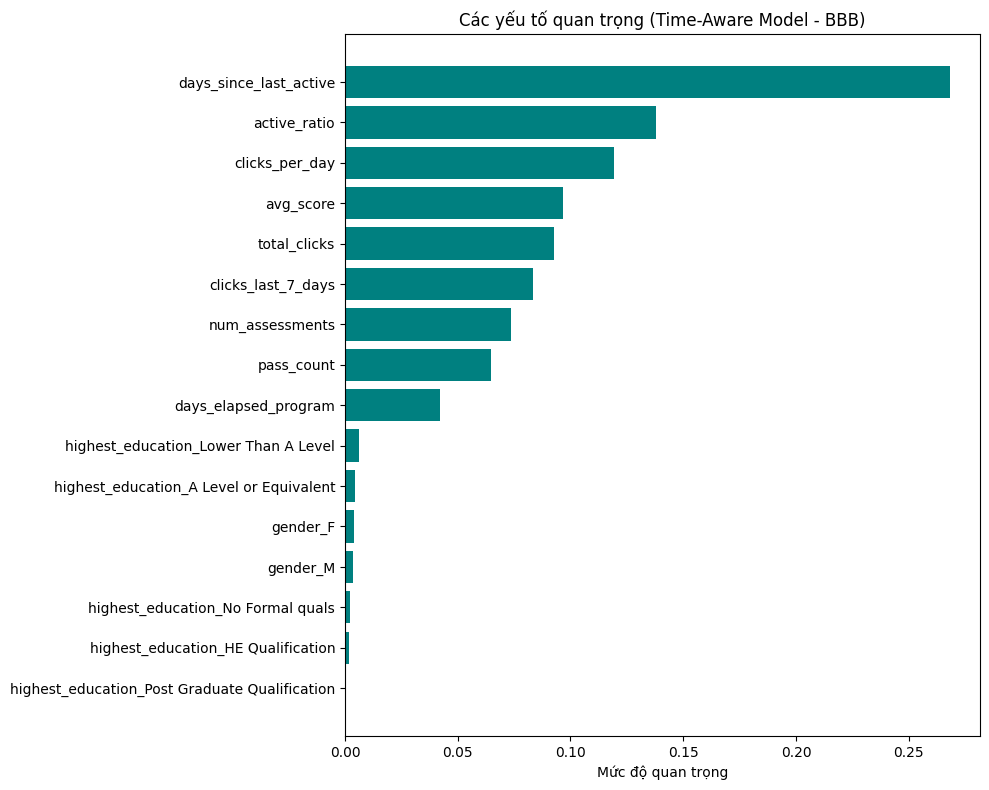

In [13]:

# =========================================================
# 7. FEATURE IMPORTANCE & VISUALIZATION
# =========================================================
feature_names = pipeline.named_steps["prep"].get_feature_names_out()
clean_names = [name.split('__')[-1] for name in feature_names]
importances = pipeline.named_steps["clf"].feature_importances_

fi_df = pd.DataFrame({"feature": clean_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(fi_df["feature"], fi_df["importance"], color='teal')
plt.title(f"Các yếu tố quan trọng (Time-Aware Model - {MODULE})")
plt.xlabel("Mức độ quan trọng")
plt.tight_layout()
plt.show()

In [14]:

# =========================================================
# 8. MÔ PHỎNG SỬ DỤNG CHO CRON JOB
# =========================================================
print("\n--- MÔ PHỎNG DỰ ĐOÁN HÀNG NGÀY ---")
# Giả sử hôm nay là ngày thứ 45 của User X
sample_input = pd.DataFrame({
    "days_elapsed_program": [45],      # QUAN TRỌNG: User đang ở ngày 45
    "total_clicks": [120],             # Tổng click từ ngày 0->45
    "clicks_per_day": [120/45],        # Tính ra ~2.6
    "active_ratio": [10/45],           # Mới học 10 ngày thôi
    "days_since_last_active": [5],     # 5 ngày rồi chưa vào
    "clicks_last_7_days": [2],         # Tuần rồi vào click có 2 cái
    "num_assessments": [1],
    "avg_score": [80],
    "pass_count": [1],
    "gender": ["M"],
    "highest_education": ["HE Qualification"]
})

risk_prob = pipeline.predict_proba(sample_input)[:, 1][0]
prediction = "NGUY CƠ CAO (Gửi Mail)" if risk_prob >= best_thresh else "An toàn"
print(f"User X (Ngày 45): Xác suất Dropout {risk_prob:.2%} -> {prediction}")


--- MÔ PHỎNG DỰ ĐOÁN HÀNG NGÀY ---
User X (Ngày 45): Xác suất Dropout 12.32% -> An toàn
